In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

In [7]:
results_path = "/home/adameisen/Documents/MIT/code/ChaoticConsciousness/__data__/propofol/VAR/VAR_Mary-Anesthesia-20160809-01_window_2.5_stride_2.5_Dec-01-2021_0914"

In [8]:
session = os.path.basename(results_path).split('_')[1]

In [13]:
results_path = "/home/adameisen/Documents/MIT/code/ChaoticConsciousness/__data__/propofol/VAR/VAR_Mary-Anesthesia-20160809-01_window_2.5_stride_2.5_Dec-01-2021_0841"

In [14]:
os.path.exists(results_path)

True

## Load Neural Data

In [9]:
filename = fr'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/{session}.mat'

print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
T = lfp.shape[0]

f = h5py.File(filename, 'r')
airPuff_binary, audio_binary = get_binary_stimuli(f)

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 79.13 seconds)


# Load Results

In [15]:
run_data = load(results_path)

In [18]:
run_params = run_data['run_params']
results = run_data['results']

In [73]:
for area in results.keys():
    results[area]['start_time'] = pd.Series(np.arange(len(results[area]))*run_params['stride'])
    results[area]['start_step'] = pd.Series(np.int0(results[area].start_time/dt))

# Plot

## Individual Areas

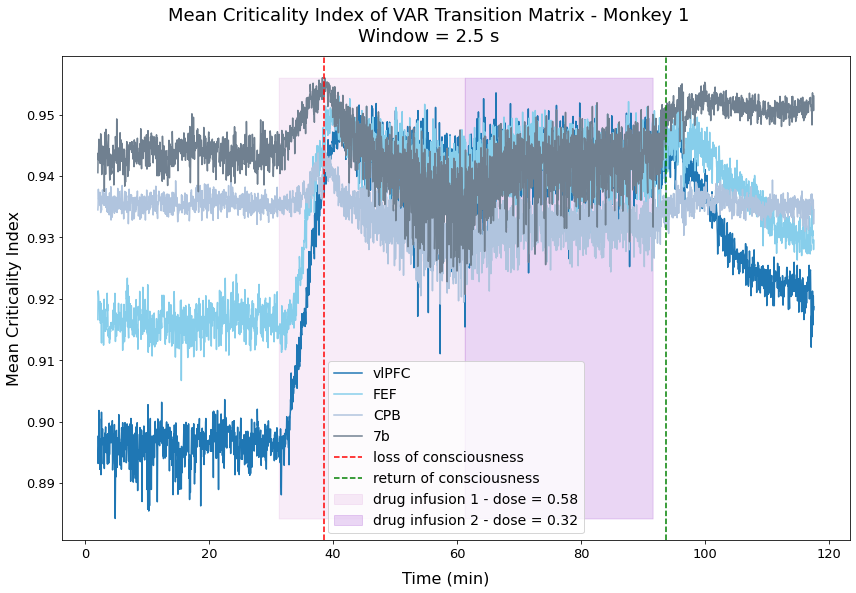

In [69]:
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

min_val = np.Inf
max_val = -np.Inf
for area, c in [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray')]:
# for area, c in [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]:
# for area, c in [('vlPFC', 'C0')]:
    start_times = results[area].start_time/60
    criticality_inds = results[area].eigs.apply(lambda x: x.mean())
    start_ind = 50
    start_times = start_times[start_ind:]
    criticality_inds = criticality_inds[start_ind:]
    ax.plot(start_times, criticality_inds, label=area, c=c)
    
    if criticality_inds.min() < min_val:
        min_val = criticality_inds.min()
    if criticality_inds.max() > max_val:
        max_val = criticality_inds.max()

# min_val = criticality_inds.min()
# max_val = criticality_inds.max()
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], run_params['stride'])/60, 
                                min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], run_params['stride'])/60, 
                        min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 2 - dose = {session_info['drugDose'][1]}")

plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")
ax.legend(fontsize=14)        
fig.text(0.52, -0.02, 'Time (min)', ha='center', fontsize=16)
ax.set_ylabel('Mean Criticality Index', fontsize=16)
ax.tick_params(labelsize=13)
plt.suptitle(f"Mean Criticality Index of VAR Transition Matrix - Monkey 1\nWindow = {run_params['window']} s", fontsize=18)
plt.tight_layout()
plt.show()

## Multipopulation

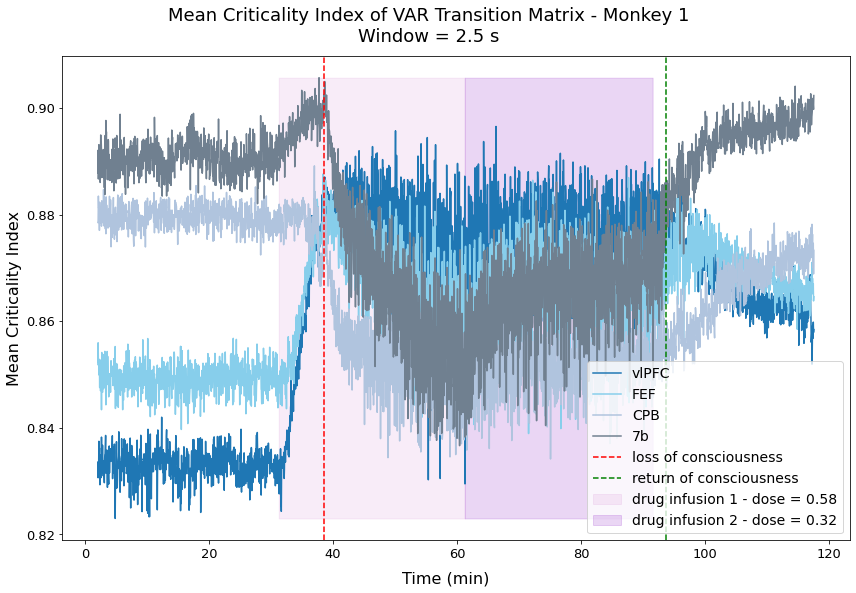

In [54]:
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

min_val = np.Inf
max_val = -np.Inf
# for area, c in [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray'), ('Thal', 'midnightblue')]:
# for area, c in [('vlPFC', 'C0')]:
for area, c in [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray')]:
    start_times = results[area].start_time/60

    unit_indices = run_params['unit_indices'][area]
    
    criticality_inds = np.zeros(len(results['all']))
    for i in range(len(criticality_inds)):
        e, _ = np.linalg.eig(results['all'].A_mat.iloc[i][unit_indices][:, unit_indices])
        criticality_inds[i] = np.abs(e).mean()
    
#     criticality_inds = results[area]['eigs'].mean(axis=1)
    start_ind = 50
    start_times = start_times[start_ind:]
    criticality_inds = criticality_inds[start_ind:]
    ax.plot(start_times, criticality_inds, label=area, c=c)
    
    if criticality_inds.min() < min_val:
        min_val = criticality_inds.min()
    if criticality_inds.max() > max_val:
        max_val = criticality_inds.max()

# min_val = criticality_inds.min()
# max_val = criticality_inds.max()
ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], run_params['stride'])/60, 
                                min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], run_params['stride'])/60, 
                        min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 2 - dose = {session_info['drugDose'][1]}")

plt.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
plt.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")
ax.legend(fontsize=14)        
fig.text(0.52, -0.02, 'Time (min)', ha='center', fontsize=16)
ax.set_ylabel('Mean Criticality Index', fontsize=16)
ax.tick_params(labelsize=13)
plt.suptitle(f"Mean Criticality Index of VAR Transition Matrix - Monkey 1\nWindow = {run_params['window']} s", fontsize=18)
plt.tight_layout()
plt.show()

# Test

In [55]:
i = 0
area = 'all'

In [86]:
unit_indices = run_params['unit_indices'][area]
T_pred = 25
row = results[area].iloc[i]
x0 = lfp[row.start_step + int(run_params['window']/dt) - 1, unit_indices]
predictions = np.zeros((T_pred, len(unit_indices)))
for t in range(T_pred):
    if t == 0:
        predictions[t] = np.concatenate([[1], x0]) @ row.A_mat_with_bias
    else:
        predictions[t] = np.concatenate([[1], predictions[t-1]]) @ row.A_mat_with_bias

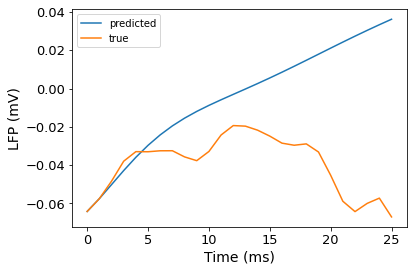

In [107]:
unit_num = 10
plt.plot(np.concatenate([[x0], predictions])[:, unit_num], label='predicted')
plt.plot(lfp[row.start_step + int(run_params['window']/dt) - 1:row.start_step + int(run_params['window']/dt) + T_pred, unit_indices[unit_num]], label='true')
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('LFP (mV)', fontsize=14)
ax = plt.gca()
ax.tick_params(labelsize=13)
plt.legend()
plt.show()